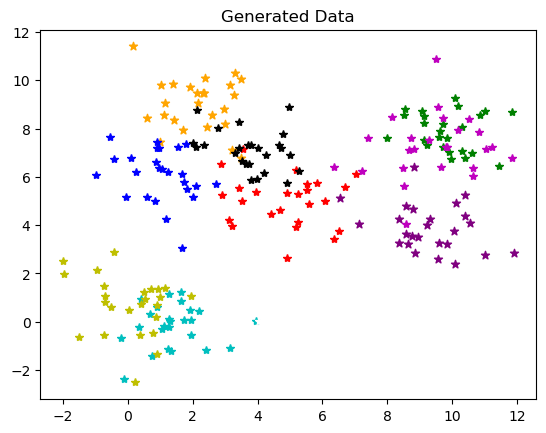

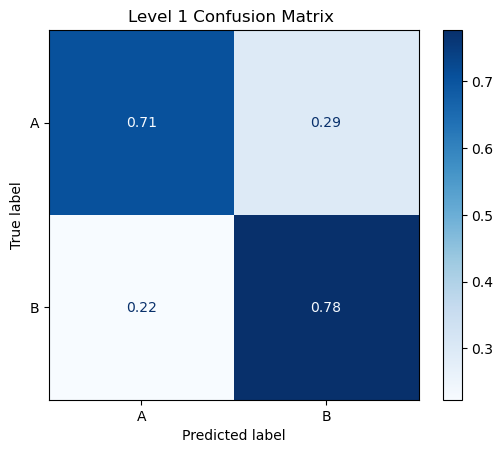

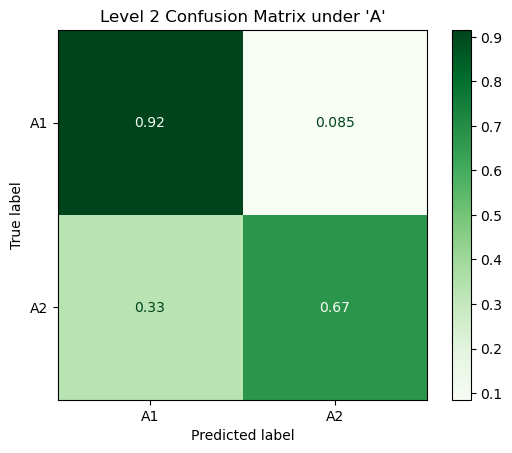

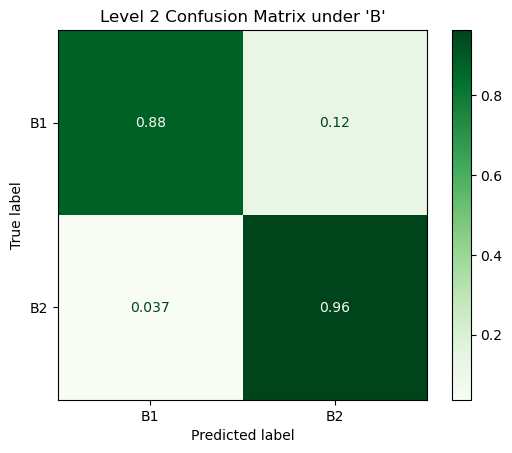

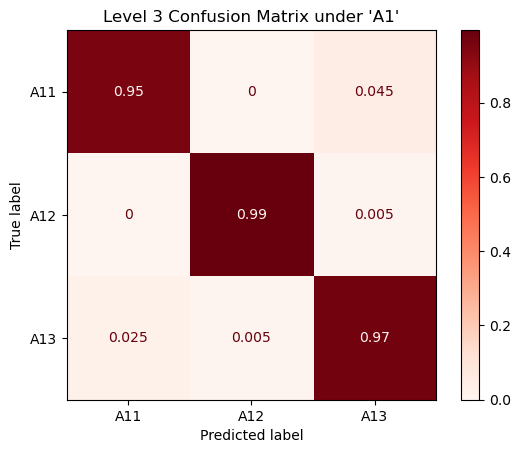

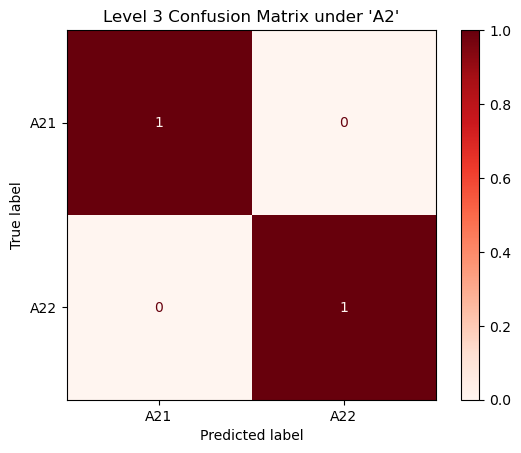

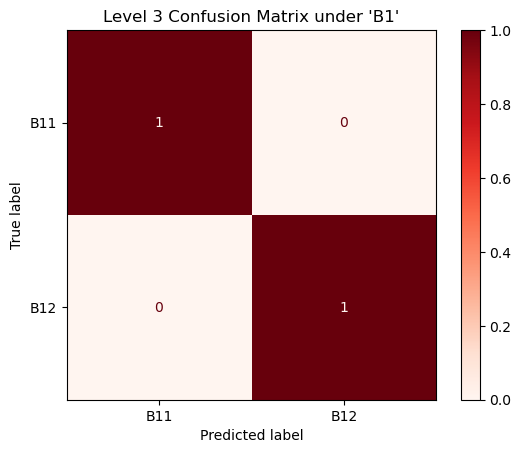

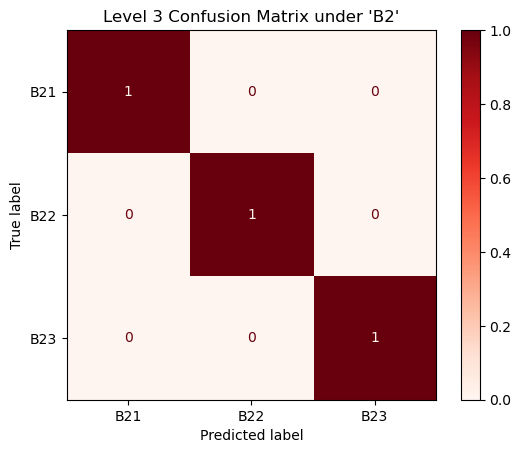

Class: A11
0.1
0.707
0.915
0.955
Class: A12
0.1
0.707
0.915
0.995
Class: A13
0.1
0.707
0.915
0.97
Class: A21
0.1
0.707
0.6725
1.0
Class: A22
0.1
0.707
0.6725
1.0
Class: B11
0.1
0.777
0.8775
1.0
Class: B12
0.1
0.777
0.8775
1.0
Class: B21
0.1
0.777
0.9633333333333334
1.0
Class: B22
0.1
0.777
0.9633333333333334
1.0
Class: B23
0.1
0.777
0.9633333333333334
1.0
Net Theoretical Accuracy: 0.64490426
Monte Carlo Estimated Net Accuracy: 0.64395


In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

hierarchy= {"A":{"A1":["A11","A12","A13"],
                                  "A2":["A21","A22"]},
            "B":{"B1":["B11","B12"],
                                  "B2":["B21","B22","B23"]}}

#Multivariable Gaussian Data Generation function for each root class
def Data_gen(Label,num_samples,num_features):
    seed=(abs(hash(Label)))%(2**32 -1)
    rng=np.random.default_rng(seed)
    mean=rng.uniform(low=0,high=10,size=num_features)
    cov=np.eye(num_features)
    Data=np.random.multivariate_normal(mean,cov,size=num_samples)
    return Data.T

X=[]
Y1=[]
Y2=[]
Y3=[]

for Level1,Level1_dict in hierarchy.items():
    for Level2,Level2_list in Level1_dict.items():
        for Level3 in Level2_list:
            Data=Data_gen(Level3,200,4)
            X.append(Data)
            Y1.extend([Level1 for i in range(200)])
            Y2.extend([Level2 for i in range(200)])
            Y3.extend([Level3 for i in range(200)])
X=np.hstack(X)
y1=np.array(Y1)
y2=np.array(Y2)
y3=np.array(Y3)
X.shape
plt.figure()
plt.plot(X[0,:25],X[1,:25],'b*')
plt.plot(X[0,200:225],X[1,200:225],'g*')
plt.plot(X[0,400:425],X[1,400:425],'r*')
plt.plot(X[0,600:625],X[1,600:625],'c*')
plt.plot(X[0,800:825],X[1,800:825],'m*')
plt.plot(X[0,1000:1025],X[1,1000:1025],'y*')
plt.plot(X[0,1200:1225],X[1,1200:1225],'k*')
plt.plot(X[0,1400:1425],X[1,1400:1425],'w*')
plt.scatter(X[0,1600:1625],X[1,1600:1625], marker='*', color='orange')
plt.scatter(X[0,1800:1825],X[1,1800:1825], marker='*', color='purple')
plt.title("Generated Data")


#Building the SoftMax Classifier
def SoftMax_Classifier(X,Y):
    num_features,num_samples=X.shape
    y_raw = Y
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_raw)  
    num_classes = len(label_encoder.classes_)

    # One-hot encode
    one_hot_y = np.eye(num_classes)[y_encoded]
    W= np.random.randn(num_classes,num_features)*0.01
    b = np.zeros((num_classes, 1))
    lr=0.01
    for epoch in range(1000):
        scores=(W@X)+b
        scores_stable = scores - np.max(scores, axis=0, keepdims=True) #Stabilization step to prevent overflow
        probs = np.exp(scores_stable) / np.sum(np.exp(scores_stable), axis=0, keepdims=True)
        grad = (probs - one_hot_y.T) / num_samples
        dW = grad@(X.T)
        db = np.sum(grad, axis=1, keepdims=True)
        
        # Update
        W -= lr * dW
        b -= lr * db
    final_scores=(W@X)+b
    final_scores_stable = final_scores - np.max(final_scores, axis=0, keepdims=True) #Stabilization step to prevent overflow
    final_probs = np.exp(final_scores_stable) / np.sum(np.exp(final_scores_stable), axis=0, keepdims=True)
    predictions = np.argmax(final_probs, axis=0)
    predicted_labels = label_encoder.inverse_transform(predictions)
    true_labels = label_encoder.inverse_transform(y_encoded)
    return predicted_labels, true_labels

#Function to gather filtered data from previous level for the classifier of the next level
def get_data_by_label(X, target_y, filter_y, desired_class):
    idx = np.where(filter_y == desired_class)[0]
    return X[:, idx], target_y[idx]


cm1_dict = {}
cm2_dict = {}
cm3_dict = {}

# Level 1: A vs B

le1 = LabelEncoder()
pred_lvl1,true_lvl1=SoftMax_Classifier(X,y1)
#Encoding the true and predicted labels to give to the Confusion Matrix
true_lvl1_encoded = le1.fit_transform(true_lvl1)
pred_lvl1_encoded = le1.transform(pred_lvl1)
labels_lvl1 = np.unique(true_lvl1)
cm1 = confusion_matrix(true_lvl1_encoded, pred_lvl1_encoded, labels=np.arange(len(labels_lvl1)))
cm1 = cm1 / np.sum(cm1, axis=1, keepdims=True)
#Storing the respective Confusion matrix and labels invovled in dictionary wise for each level, here the level being level 1
cm1_dict["root"] = (cm1, labels_lvl1)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=le1.classes_)
disp1.plot(cmap="Blues")
plt.title(f"Level 1 Confusion Matrix ")
plt.show()

cm2_dict = {}
le2_dict = {}

for lvl1_class in np.unique(y1):
    X_lvl2, y2_lvl2 = get_data_by_label(X, y2, y1, lvl1_class)
    pred_lvl2, true_lvl2 = SoftMax_Classifier(X_lvl2, y2_lvl2)

    le2_local = LabelEncoder()
    true_lvl2_encoded = le2_local.fit_transform(true_lvl2)
    pred_lvl2_encoded = le2_local.transform(pred_lvl2)

    cm2 = confusion_matrix(true_lvl2_encoded, pred_lvl2_encoded, labels=np.arange(len(le2_local.classes_)))
    cm2 = cm2 / np.sum(cm2, axis=1, keepdims=True)

    cm2_dict[lvl1_class] = cm2
    le2_dict[lvl1_class] = le2_local

    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=le2_local.classes_)
    disp1.plot(cmap="Greens")
    plt.title(f"Level 2 Confusion Matrix under '{lvl1_class}'")
    plt.show()

#Level3
cm3_dict = {}
le3_dict = {}

for lvl2_class in np.unique(y2):
    X_lvl3, y3_lvl3 = get_data_by_label(X, y3, y2, lvl2_class)

    le3_local = LabelEncoder()
    y3_lvl3_encoded = le3_local.fit_transform(y3_lvl3)

    pred_lvl3, _ = SoftMax_Classifier(X_lvl3, y3_lvl3)
    pred_lvl3_encoded = le3_local.transform(pred_lvl3)

    cm3 = confusion_matrix(y3_lvl3_encoded, pred_lvl3_encoded, labels=np.arange(len(le3_local.classes_)))
    cm3 = cm3 / np.sum(cm3, axis=1, keepdims=True)

    cm3_dict[lvl2_class] = cm3
    le3_dict[lvl2_class] = le3_local

    disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=le3_local.classes_)
    disp3.plot(cmap="Reds")
    plt.title(f"Level 3 Confusion Matrix under '{lvl2_class}'")
    plt.show()

#Total Accuracy as per logic
def compute_net_accuracy(y1, y2, y3, cm1, cm2_dict, cm3_dict, le1, le2_dict, le3_dict):
    unique_leaf_classes, counts = np.unique(y3, return_counts=True)
    total_samples = len(y3)

    net_accuracy = 0.0

    for leaf_class, count in zip(unique_leaf_classes, counts):
        #Initial probability that the input given to the classifier is of a given leaf class
        p_leaf = count / total_samples
        
        idx = np.where(y3 == leaf_class)[0][0]#Retrieves the index of the first element of the required leaf_class in the list
        lvl2_class = y2[idx]
        lvl1_class = y1[idx]

        
        lvl1_idx = le1.transform([lvl1_class])[0]
        lvl2_idx_within_lvl1 = le2_dict[lvl1_class].transform([lvl2_class])[0]
        lvl3_idx_within_lvl2 = le3_dict[lvl2_class].transform([leaf_class])[0]

        p1 = cm1[lvl1_idx, lvl1_idx]
        p2 = cm2_dict[lvl1_class][lvl2_idx_within_lvl1, lvl2_idx_within_lvl1]
        p3 = cm3_dict[lvl2_class][lvl3_idx_within_lvl2, lvl3_idx_within_lvl2]

        print("Class:", leaf_class)
        print(p_leaf)
        print(p1)
        print(p2)
        print(p3)

        net_accuracy += p_leaf * p1 * p2 * p3

    return net_accuracy



    
net_acc = compute_net_accuracy(y1, y2, y3, cm1, cm2_dict, cm3_dict, le1, le2_dict, le3_dict)
print("Net Theoretical Accuracy:", net_acc)


def monte_carlo_accuracy(y1, y2, y3, cm1, cm2_dict, cm3_dict, le1, le2_dict, le3_dict, N=1000):
    unique_leaf_classes, probs = np.unique(y3, return_counts=True)
    probs = probs / np.sum(probs)

    correct = 0

    for _ in range(N):
        # 1. Sample a leaf class based on prior probability
        true_leaf = np.random.choice(unique_leaf_classes, p=probs)

        # 2. Get its true level-2 and level-1 parents
        idx = np.where(y3 == true_leaf)[0][0]
        true_lvl2 = y2[idx]
        true_lvl1 = y1[idx]

        # 3. Encode the levels
        lvl1_idx = le1.transform([true_lvl1])[0]
        lvl2_idx = le2_dict[true_lvl1].transform([true_lvl2])[0]
        lvl3_idx = le3_dict[true_lvl2].transform([true_leaf])[0]

        # 4. Simulate prediction at each level using CM rows as probability distributions
        pred_lvl1_idx = np.random.choice(len(cm1), p=cm1[lvl1_idx])
        if pred_lvl1_idx != lvl1_idx:
            continue  # Incorrect at level 1

        cm2 = cm2_dict[true_lvl1]
        pred_lvl2_idx = np.random.choice(len(cm2), p=cm2[lvl2_idx])
        if pred_lvl2_idx != lvl2_idx:
            continue  # Incorrect at level 2

        cm3 = cm3_dict[true_lvl2]
        pred_lvl3_idx = np.random.choice(len(cm3), p=cm3[lvl3_idx])
        if pred_lvl3_idx != lvl3_idx:
            continue  # Incorrect at level 3

        correct += 1

    return correct / N

empirical_accuracy = monte_carlo_accuracy(
    y1, y2, y3, cm1, cm2_dict, cm3_dict, le1, le2_dict, le3_dict, N=100000
)
print("Monte Carlo Estimated Net Accuracy:", empirical_accuracy)
    